In [6]:
import tensorflow as tf
import numpy as np
import json
import pickle

In [7]:
import sys
import tensorflow.keras as keras
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras import backend as K
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

GPU is available


In [2]:
tf.__version__

'2.13.0'

In [4]:
model = keras.models.load_model('saved_models/two_layer_mlp.keras')

In [5]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_2 (Dense)             (None, 200)               157000    
                                                                 
 dense_3 (Dense)             (None, 100)               20100     
                                                                 
 dense_4 (Dense)             (None, 10)                1010      
                                                                 
Total params: 178110 (695.74 KB)
Trainable params: 178110 (695.74 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [53]:
dataset = (tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(64)).batch(32, drop_remainder=True)

functions = []
transposed_weights = []
for i in range(len(model.layers)):
    functions.append(K.function([model.layers[i].input],model.layers[i].output))
    if len(model.layers[i].get_weights()) == 0:
        transposed_weights.append([])
    else:
        transposed_weights.append(tf.transpose(model.layers[i].get_weights()[0]))

In [14]:
batch, _ = next(iter(dataset))
output = functions[0](batch)

In [19]:
output = functions[1](output)

In [51]:
output.shape

(32, 100)

In [54]:
transposed_weights[1]

<tf.Tensor: shape=(100, 784), dtype=float32, numpy=
array([[-0.02909933, -0.00972559,  0.07991979, ...,  0.04148942,
         0.07575217,  0.03054222],
       [ 0.01924727,  0.01127031,  0.03678724, ...,  0.04574993,
         0.07600357, -0.02977445],
       [ 0.05283608,  0.06354788,  0.05715333, ...,  0.01493069,
        -0.00899496, -0.07083454],
       ...,
       [ 0.00092193, -0.05972512, -0.00410009, ..., -0.07463339,
         0.06129499,  0.04550619],
       [-0.04778087,  0.06049088, -0.00303373, ..., -0.05267476,
         0.00212701, -0.07623545],
       [-0.06474704, -0.00022946,  0.02267285, ...,  0.08136743,
         0.05228175,  0.04833503]], dtype=float32)>

In [154]:
def calc_average_activation_and_signals(model, file_path_activation, file_path_signals):
    dataset = (tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(64)).batch(32, drop_remainder=True)

    functions = []
    transposed_weights = []
    for i in range(len(model.layers)):
        functions.append(K.function([model.layers[i].input],model.layers[i].output))
        if len(model.layers[i].get_weights()) == 0:
            transposed_weights.append([])
        else:
            transposed_weights.append(tf.transpose(model.layers[i].get_weights()[0]))

    average_signals_per_layer = []
    average_activations_per_layer = []
    print("Starting with calculations")
    for i, (batch, y) in enumerate(dataset):
        print("Currently at batch: " + str(i))

        output = functions[0](batch)
        if i == 0:
            average_activations_per_layer.append(tf.expand_dims(tf.reduce_mean(output, axis=0), axis=0))
        else:
            average_activations_per_layer[0] = np.concatenate([average_activations_per_layer[0], tf.expand_dims(tf.reduce_mean(output, axis=0), axis=0)], axis=0)

        for j in range(1, len(functions)):
            output = functions[j](output)
            if i == 0:
                average_activations_per_layer.append(tf.expand_dims(tf.reduce_mean(output, axis=0), axis=0))
                average_signals_per_layer.append(tf.expand_dims(tf.reduce_mean(tf.einsum('bi,ij->bji', output, transposed_weights[j]),axis=0), axis=0))
            else:
                average_activations_per_layer[j] = np.concatenate([average_activations_per_layer[j], tf.expand_dims(tf.reduce_mean(output, axis=0), axis=0)], axis=0)
                average_signals_per_layer[j-1] = np.concatenate([average_signals_per_layer[j-1], tf.expand_dims(tf.reduce_mean(tf.einsum('bi,ij->bji', output, transposed_weights[j]),axis=0), axis=0)],axis=0)

        print("Done with calculations, now averaging results..")

    for index in range(len(average_activations_per_layer)):
        average_activations_per_layer[index] = tf.reduce_mean(average_activations_per_layer[index], axis=0).numpy()

    for index in range(len(average_signals_per_layer)):
        average_signals_per_layer[index] = tf.reduce_mean(average_signals_per_layer[index], axis=0).numpy()

    print("Done with calculations. Saving to file.")

    with open(file_path_activation, 'wb') as handle:
        pickle.dump(average_activations_per_layer, handle, protocol=pickle.HIGHEST_PROTOCOL)

    with open(file_path_signals, 'wb') as handle:
        pickle.dump(average_signals_per_layer, handle, protocol=pickle.HIGHEST_PROTOCOL)

    return

In [32]:
transposed_weights = tf.transpose(model.layers[1].get_weights()[0], perm=[1, 0])

In [108]:
res = tf.reduce_mean(tf.einsum('bi,ij->bij', output, transposed_weights[1]),axis=0)

In [137]:
tf.einsum('bi,ij->bij', output, transposed_weights[0]),axis=0)

<tf.Tensor: shape=(32, 784), dtype=float32, numpy=
array([[-0.05037457,  0.37428117,  0.1647588 , ..., -0.44607025,
         0.22508907,  0.75456023],
       [-0.2653794 ,  0.02401102,  0.21583462, ..., -0.08780482,
        -0.3789558 ,  0.88147354],
       [-0.16947095,  0.18668845,  0.47910312, ..., -0.2715365 ,
         0.16939394,  0.6167176 ],
       ...,
       [-0.3357129 ,  0.1576246 ,  0.24087429, ..., -0.13315487,
        -0.09869003,  0.8954811 ],
       [-0.5503101 ,  0.11794269,  0.15482262, ..., -0.44947174,
         0.17222115,  0.6397081 ],
       [-0.8587322 , -0.02315772,  0.28890133, ..., -0.34862518,
         0.18368149,  0.53419876]], dtype=float32)>

In [119]:
tf.reduce_mean(test, axis=-1)

<tf.Tensor: shape=(100, 784), dtype=float32, numpy=
array([[-3.6374168e-03, -1.2156982e-03,  9.9899732e-03, ...,
         5.1861778e-03,  9.4690211e-03,  3.8177781e-03],
       [ 5.3318413e-03,  3.1220790e-03,  1.0190731e-02, ...,
         1.2673559e-02,  2.1054359e-02, -8.2480628e-03],
       [ 1.1613487e-35,  1.3967965e-35,  1.2562429e-35, ...,
         3.2817985e-36, -1.9771120e-36, -1.5569589e-35],
       ...,
       [ 5.7620462e-04, -3.7328199e-02, -2.5625573e-03, ...,
        -4.6645857e-02,  3.8309366e-02,  2.8441366e-02],
       [-1.7917827e-02,  2.2684075e-02, -1.1376506e-03, ...,
        -1.9753037e-02,  7.9763029e-04, -2.8588297e-02],
       [-6.0700372e-02, -2.1512154e-04,  2.1255786e-02, ...,
         7.6282002e-02,  4.9014132e-02,  4.5314100e-02]], dtype=float32)>

In [155]:
a, b = calc_average_activation_and_signals(model, "", "")

Starting with calculations
Currently at batch: 0
Currently at batch: 1
Currently at batch: 2
Currently at batch: 3
Currently at batch: 4
Currently at batch: 5
Currently at batch: 6
Currently at batch: 7
Currently at batch: 8
Currently at batch: 9
Currently at batch: 10
Currently at batch: 11
Currently at batch: 12
Currently at batch: 13
Currently at batch: 14
Currently at batch: 15
Currently at batch: 16
Currently at batch: 17
Currently at batch: 18
Currently at batch: 19
Currently at batch: 20
Currently at batch: 21
Currently at batch: 22
Currently at batch: 23
Currently at batch: 24
Currently at batch: 25
Currently at batch: 26
Currently at batch: 27
Currently at batch: 28
Currently at batch: 29
Currently at batch: 30
Currently at batch: 31
Currently at batch: 32
Currently at batch: 33
Currently at batch: 34
Currently at batch: 35
Currently at batch: 36
Currently at batch: 37
Currently at batch: 38
Currently at batch: 39
Currently at batch: 40
Currently at batch: 41
Currently at batc

In [159]:
for i in range(len(a)):
    a[i] = tf.reduce_mean(a[i], axis=0).numpy()

In [162]:
a[2]

array([-5.100979 , -4.1604185, -2.538866 , -2.4602315, -3.859214 ,
       -2.2906702, -4.1809278, -3.4716942, -2.2140117, -2.7867558],
      dtype=float32)

In [96]:
 list = []
list.append(tf.reduce_mean(output, axis=0))

In [115]:
list = []
list.append(tf.expand_dims(tf.reduce_mean(output, axis=0), axis=0))
list[0] = np.concatenate([list[0], tf.expand_dims(tf.reduce_mean(output, axis=0), axis=0)], axis=0)
list[0]

array([[1.2500000e-01, 2.7701807e-01, 2.1980222e-34, 4.0625000e-01,
        6.2500000e-02, 8.7500000e-01, 5.3125846e-01, 2.5000000e-01,
        3.7500000e-01, 1.5625000e-01, 2.8127480e-01, 1.0000000e+00,
        6.8750000e-01, 0.0000000e+00, 6.2500000e-01, 9.0174598e-01,
        7.5000000e-01, 6.5625000e-01, 9.6875000e-01, 5.6250000e-01,
        7.1869034e-01, 6.2500000e-02, 6.5625000e-01, 9.1336556e-02,
        0.0000000e+00, 3.1250041e-02, 7.1875000e-01, 9.3750000e-02,
        8.4375000e-01, 9.3749978e-02, 3.1250000e-01, 5.6250000e-01,
        6.2503803e-01, 7.1875000e-01, 9.0625000e-01, 1.0000000e+00,
        1.5625037e-01, 7.5000000e-01, 7.8125000e-01, 2.1875000e-01,
        4.3750000e-01, 0.0000000e+00, 1.2500000e-01, 7.8125000e-01,
        5.6250000e-01, 9.0625000e-01, 9.6872330e-01, 8.1780565e-01,
        3.1250000e-02, 1.0000000e+00, 9.0625000e-01, 6.5625000e-01,
        1.0000000e+00, 9.3751585e-01, 5.3125000e-01, 0.0000000e+00,
        1.0000000e+00, 6.5625000e-01, 3.1250000e

In [145]:
tf.reduce_mean(b[1],axis=0).shape

TensorShape([10, 100])

In [57]:
res = tf.matmul(output, transposed_weights[1])

<tf.Tensor: shape=(32, 784), dtype=float32, numpy=
array([[-0.05037457,  0.37428117,  0.1647588 , ..., -0.44607025,
         0.22508907,  0.75456023],
       [-0.2653794 ,  0.02401102,  0.21583462, ..., -0.08780482,
        -0.3789558 ,  0.88147354],
       [-0.16947095,  0.18668845,  0.47910312, ..., -0.2715365 ,
         0.16939394,  0.6167176 ],
       ...,
       [-0.3357129 ,  0.1576246 ,  0.24087429, ..., -0.13315487,
        -0.09869003,  0.8954811 ],
       [-0.5503101 ,  0.11794269,  0.15482262, ..., -0.44947174,
         0.17222115,  0.6397081 ],
       [-0.8587322 , -0.02315772,  0.28890133, ..., -0.34862518,
         0.18368149,  0.53419876]], dtype=float32)>

In [149]:
result_reshaped = tf.einsum('bi,ij->bji', output, transposed_weights[1])

In [153]:
tf.reduce_mean(result_reshaped,axis=0)

<tf.Tensor: shape=(784, 100), dtype=float32, numpy=
array([[-3.6374168e-03,  5.3318413e-03,  1.1613487e-35, ...,
         5.7620462e-04, -1.7917827e-02, -6.0700372e-02],
       [-1.2156982e-03,  3.1220790e-03,  1.3967965e-35, ...,
        -3.7328199e-02,  2.2684075e-02, -2.1512154e-04],
       [ 9.9899732e-03,  1.0190731e-02,  1.2562429e-35, ...,
        -2.5625573e-03, -1.1376506e-03,  2.1255786e-02],
       ...,
       [ 5.1861778e-03,  1.2673559e-02,  3.2817985e-36, ...,
        -4.6645857e-02, -1.9753037e-02,  7.6282002e-02],
       [ 9.4690211e-03,  2.1054359e-02, -1.9771120e-36, ...,
         3.8309366e-02,  7.9763029e-04,  4.9014132e-02],
       [ 3.8177781e-03, -8.2480628e-03, -1.5569589e-35, ...,
         2.8441366e-02, -2.8588297e-02,  4.5314100e-02]], dtype=float32)>

In [31]:
model.layers[1].get_weights()[0].shape

(784, 100)

In [5]:
x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

In [4]:
dataset = (tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(64)).batch(32)

2024-03-27 15:37:39.886514: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-03-27 15:37:39.886537: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-03-27 15:37:39.886543: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-03-27 15:37:39.886612: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-27 15:37:39.886638: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [51]:
img, label = next(dataset.as_numpy_iterator())

In [64]:
result = intermediate_output(img)
result.shape

TensorShape([32, 784])

In [70]:
res2 = tf.concat(axis=0, values = [result, intermediate_output(img)])

In [73]:
res3 = tf.concat(axis=0, values = [res2, intermediate_output(img)])

In [22]:
model.get_layer("dense_2").get_weights()[0]

array([[-0.01533557, -0.07056466, -0.07948228, ..., -0.04078073,
        -0.01247036,  0.03600316],
       [-0.00466596, -0.04265548, -0.06019691, ..., -0.04801249,
         0.00765232,  0.02882886],
       [ 0.04006352,  0.02674455, -0.0058572 , ..., -0.0750692 ,
        -0.07353111, -0.07292527],
       ...,
       [-0.02038546,  0.05478568,  0.032463  , ..., -0.01679661,
         0.05295084,  0.03173396],
       [ 0.07286537, -0.02405785, -0.07391192, ...,  0.07852083,
         0.04939954, -0.03286201],
       [ 0.05876999, -0.02279257, -0.07745385, ...,  0.04657277,
        -0.07950619, -0.03097196]], dtype=float32)

In [74]:
tf.reduce_mean(res3, axis=0)

<tf.Tensor: shape=(784,), dtype=float32, numpy=
array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.00000

In [82]:
large_set = []
for i, (batch, y) in enumerate(dataset):
    if i == 0:
        large_set.append(intermediate_output1(batch))
    else:
        large_set[0] = tf.concat(axis=0, values = [large_set[0], intermediate_output1(batch)])

In [93]:
stuff = []
stuff.append(tf.reduce_mean(large_set[0], axis=0).numpy())
stuff.append(tf.reduce_mean(large_set[0], axis=0).numpy())

In [81]:
import json


In [82]:
import pickle

In [28]:
len(model.layers)

3

In [30]:
for index in range(len(model.layers)-1):
    print(index)

0
1


(60000, 28, 28)

In [31]:
model.layers[0]

In [46]:
def compute_outgoing_signals(model, x):
    # Initialize list to store outgoing signals for each layer
    outgoing_signals_per_layer = []
    # Initialize inputs with the input data
    inputs = x

    # Iterate through the layers of the model
    for index in range(len(model.layers)-1):
        # Compute the activations of the current layer
        activations = model.layers[index](inputs)
        # Get the weights and biases of the current layer
        weights, biases = model.layers[index+1].get_weights()
        # Compute the outgoing signals (weight times activation)
        expanded_activations = np.expand_dims(activations, axis=-1)  # Shape: (32, 784, 1)
        expanded_weights = np.expand_dims(weights, axis=0)  # Shape: (1, 784, 100)
        outgoing_signals = expanded_activations * expanded_weights
        # Store the outgoing signals for the current layer
        outgoing_signals_per_layer.append(outgoing_signals)
        # Update inputs for the next layer
        inputs = activations

    return outgoing_signals_per_layer

In [8]:
with open('saved_precalculations/two_layer_mlp/average_signals.pickle', 'rb') as handle:
    average_signal_per_layer = pickle.load(handle)

In [18]:
average_signal_per_layer[2].shape

(100, 10)

In [70]:
model.layers

In [47]:
x_batch, _ = next(iter(dataset))
outgoing_signals_batch = compute_outgoing_signals(model, x_batch)

In [57]:
(tf.reduce_sum(outgoing_signals_batch[0], axis=0) + tf.reduce_sum(outgoing_signals_batch[0], axis=0)) / 64

<tf.Tensor: shape=(784, 100), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [72]:
dataset = (tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(64)).batch(32)
summed_signal_per_layer = []

print("Starting with calculations")
for i, (batch, _) in enumerate(dataset):
    print("Currently at batch: " + str(i))
    inputs = batch
    for j in range(len(model.layers)-1):
        # Compute the activations of the current layer
        activations = model.layers[j](inputs)
        # Get the weights and biases of the current layer
        weights, biases = model.layers[j+1].get_weights()
        # Compute the outgoing signals (weight times activation)
        expanded_activations = np.expand_dims(activations, axis=-1)
        expanded_weights = np.expand_dims(weights, axis=0)
        outgoing_signals = expanded_activations * expanded_weights
        # Store the outgoing signals for the current layer
        if i == 0:
            summed_signal_per_layer.append(tf.reduce_sum(outgoing_signals, axis=0))
        else:
            summed_signal_per_layer[j] += tf.reduce_sum(outgoing_signals, axis=0)
        # Update inputs for the next layer
        inputs = activations


print("Done with calculations, averaging results..")
average_signal_per_layer = []
for matrix in summed_signal_per_layer:
    average_signal_per_layer.append((matrix / x_train.shape[0]).numpy())

print("Saving file..")
with open('saved_precalculations/simple_mlp/average_signals.pickle', 'wb') as handle:
    pickle.dump(average_signal_per_layer, handle, protocol=pickle.HIGHEST_PROTOCOL)

Starting with calculations
Currently at batch: 0
Currently at batch: 1
Currently at batch: 2
Currently at batch: 3
Currently at batch: 4
Currently at batch: 5
Currently at batch: 6
Currently at batch: 7
Currently at batch: 8
Currently at batch: 9
Currently at batch: 10
Currently at batch: 11
Currently at batch: 12
Currently at batch: 13
Currently at batch: 14
Currently at batch: 15
Currently at batch: 16
Currently at batch: 17
Currently at batch: 18
Currently at batch: 19
Currently at batch: 20
Currently at batch: 21
Currently at batch: 22
Currently at batch: 23
Currently at batch: 24
Currently at batch: 25
Currently at batch: 26
Currently at batch: 27
Currently at batch: 28
Currently at batch: 29
Currently at batch: 30
Currently at batch: 31
Currently at batch: 32
Currently at batch: 33
Currently at batch: 34
Currently at batch: 35
Currently at batch: 36
Currently at batch: 37
Currently at batch: 38
Currently at batch: 39
Currently at batch: 40
Currently at batch: 41
Currently at batc

In [29]:
dataset = (tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(64)).batch(32)

In [30]:
dataset_size = sum(1 for _ in dataset)

In [34]:
dataset_size // 100

18

In [35]:
dataset_size = sum(1 for _ in dataset)
one_percent_size = dataset_size // 100

# Take the first 1% of the dataset
one_percent_dataset = dataset.take(one_percent_size)

In [37]:
for i, (batch, _) in enumerate(one_percent_dataset):
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


In [14]:
with open('saved_precalculations/simple_mlp/average_signals.pickle', 'rb') as handle:
    average_signal_per_layer = pickle.load(handle)

json_w = []
for element in average_signal_per_layer:
    python_list = []
    for i in range(0, average_signal_per_layer[0].shape[0], 100):
        chunk = average_signal_per_layer[0][i:i+100].tolist()
        python_list.extend(chunk)
    json_w.append(json.dumps(python_list))


In [17]:
with open('saved_precalculations/simple_mlp/average_signals.pickle', 'rb') as handle:
    average_signal_per_layer = pickle.load(handle)

In [23]:
average_signal_per_layer[1].shape

(100, 10)

In [7]:
python_list = []
for i in range(0, average_signal_per_layer[0].shape[0], 100):
    chunk = average_signal_per_layer[0][i:i+100].tolist()
    python_list.extend(chunk)


In [15]:
json.dumps(python_list)

'[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

In [7]:
with open('saved_precalculations/simple_mlp/average_activations.pickle', 'rb') as handle:
    layer_outputs = pickle.load(handle)

json_w = []
for element in layer_outputs:
    json_w.append(json.dumps(element.tolist()))

In [8]:
print(json_w[0])

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.002099999925121665, 0.007833333685994148, 0.003599999938160181, 0.0001500000071246177, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00026666666963137686, 0.0009166667005047202, 0.009283333085477352, 0.024283332750201225, 0.0437166653573513, 0.0640999972820282, 0.12013333290815353, 0.16073334217071533, 0.17418333888053894, 0.1774333417415619, 0.18931667506694794, 0.1741500049829483, 0.18693333864212036, 0.15365000069141388, 0.10011667013168335, 0.07123333215713501, 0.053816668689250946, 0.0213666670024395, 0.0100833335891366, 0.003533333307132125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0010666666785255075, 0.0007000000332482159, 0.006950000301003456, 0.005483333487063646, 0.0471000000834465, 0.13840000331401825, 0.2641833424568176, 0.5066166520118713, 0.8668000102043152, 1.2900832891464233, 1.8703500032424927, 2.5299501419067383, 3.2016167640686035, 3.6255500316619873, 3.7219834327697754, 3.3925

In [65]:
model = keras.models.load_model('saved_models/simple_mlp.keras')
dataset = (tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(64)).batch(32)
partial_output_models = []

dataset_size = sum(1 for _ in dataset)
one_percent_size = dataset_size // 100

# Take the first 1% of the dataset
one_percent_dataset = dataset.take(one_percent_size)

# Iterate through all layer names and create sub-models providing the output of a specific layer.
# Not the most efficient way, as you need to recompute all but the last layer 1-n times, TODO: Optimize!
for name in list(map(lambda x: x.name, model.layers)):
    partial_output_models.append(tf.keras.Model(model.input, model.get_layer(name).output))

print("Starting with calculations")
layer_outputs = []
for i, (batch, y) in enumerate(one_percent_dataset):
    print("Currently at batch: " + str(i))
    for j, model in enumerate(partial_output_models):
        if i == 0:
            layer_outputs.append(model(batch))
        else:
            layer_outputs[j] = tf.concat(axis=0, values=[layer_outputs[j], model(batch)])
        # TODO: Sum or keep the running average of the result
        # TODO: batch results need to be split into single results

print("Done with calculations")
for i in range(len(layer_outputs)):
    layer_outputs[i] = tf.transpose(layer_outputs[i]).numpy()

with open('saved_precalculations/simple_mlp/subset_activations_3.pickle', 'wb') as handle:
    pickle.dump(layer_outputs, handle, protocol=pickle.HIGHEST_PROTOCOL)

Starting with calculations
Currently at batch: 0
Currently at batch: 1
Currently at batch: 2
Currently at batch: 3
Currently at batch: 4
Currently at batch: 5
Currently at batch: 6
Currently at batch: 7
Currently at batch: 8
Currently at batch: 9
Currently at batch: 10
Currently at batch: 11
Currently at batch: 12
Currently at batch: 13
Currently at batch: 14
Currently at batch: 15
Currently at batch: 16
Currently at batch: 17
Done with calculations


In [66]:
with open('saved_precalculations/simple_mlp/subset_activations_1.pickle', 'rb') as handle:
    layer_outputs = pickle.load(handle)

In [76]:
layer_outputs[1][25]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [58]:
with open('saved_precalculations/simple_mlp/subset_activations_1.pickle', 'wb') as handle:
    pickle.dump(layer_outputs, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [94]:
json_w = []
for element in stuff:
    json_w.append(element.tolist())
response = json.dumps(json_w)

In [95]:
response

'[[1650.4599609375, 742.5913696289062, 1797.7696533203125, 1578.7701416015625, 1573.10546875, 888.1036376953125, 1529.54443359375, 1305.1412353515625, 2145.34765625, 876.2327880859375, 2169.4833984375, 1395.754638671875, 1520.2864990234375, 3025.8759765625, 806.6834716796875, 2444.055419921875, 681.7911987304688, 1433.0341796875, 1054.2655029296875, 1069.08447265625, 1288.3643798828125, 1627.4810791015625, 1071.396484375, 1461.8997802734375, 1740.0947265625, 0.0, 2064.998046875, 1953.62890625, 1292.3072509765625, 0.0, 895.1784057617188, 1441.1375732421875, 1142.8355712890625, 733.734130859375, 1432.9073486328125, 2307.96240234375, 0.0, 541.4074096679688, 2346.24658203125, 6.52096132398583e-05, 631.4990234375, 1554.7786865234375, 1009.2933349609375, 1147.172119140625, 1100.331787109375, 955.6749267578125, 988.1032104492188, 511.66094970703125, 231.30990600585938, 955.1998901367188, 1311.2796630859375, 1430.2347412109375, 1499.5528564453125, 944.4180297851562, 1253.800537109375, 1618.406

In [56]:
intermediate_output = tf.keras.Model(model.input, model.get_layer('flatten_1').output)
intermediate_output1 = tf.keras.Model(model.input, model.get_layer('dense_2').output)

In [58]:
intermediate_output1(img)

<tf.Tensor: shape=(32, 100), dtype=float32, numpy=
array([[1.8013880e+00, 0.0000000e+00, 0.0000000e+00, ..., 6.9637140e+02,
        4.8980615e+02, 0.0000000e+00],
       [0.0000000e+00, 9.7900433e+02, 2.2641006e+03, ..., 4.0205703e+03,
        0.0000000e+00, 0.0000000e+00],
       [4.7861475e+03, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        5.7747949e+03, 0.0000000e+00],
       ...,
       [6.0205923e+03, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        6.6211240e+03, 0.0000000e+00],
       [1.0928689e+03, 3.0638411e+03, 1.1789032e+03, ..., 1.0781008e+03,
        3.1599551e+03, 0.0000000e+00],
       [2.8337412e+03, 2.8360474e+03, 0.0000000e+00, ..., 9.5945483e+02,
        0.0000000e+00, 4.5812515e+02]], dtype=float32)>

In [44]:
img.shape

(28, 28)

In [32]:
model.get_layer(0)

ValueError: No such layer: 0. Existing layers are: ['flatten_1', 'dense_2', 'dense_3'].

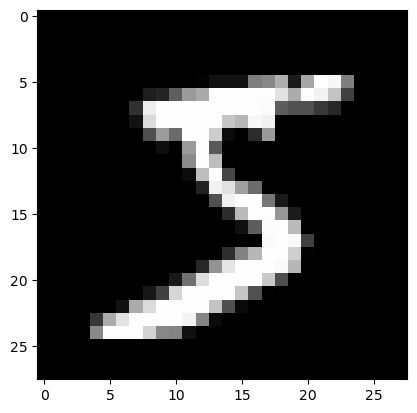

In [64]:
plt.imshow(x_train[0], cmap='gray')

In [5]:
model = keras.Sequential()
model.add(keras.Input(shape=(28,28,)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 100)               78500     
                                                                 
 dense_1 (Dense)             (None, 10)                1010      
                                                                 
Total params: 79510 (310.59 KB)
Trainable params: 79510 (310.59 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2023-08-23 10:38:45.338190: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2023-08-23 10:38:45.338210: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-08-23 10:38:45.338220: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-08-23 10:38:45.338284: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-08-23 10:38:45.338474: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = keras.optimizers.Adam()
model.compile(optimizer=optimizer, loss=loss_fn, metrics=["acc"])

In [7]:
model.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=(x_test, y_test))

Epoch 1/10
  14/1875 [..............................] - ETA: 7s - loss: 99.2999 - acc: 0.3705   

2023-08-23 10:39:19.942351: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-23 10:39:19.958066: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


1873/1875 [============================>.] - ETA: 0s - loss: 15.3907 - acc: 0.8422

2023-08-23 10:39:27.210848: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 8s 4ms/step - loss: 15.3891 - acc: 0.8422 - val_loss: 17.7413 - val_acc: 0.8317
Epoch 2/10
1875/1875 [==============================] - 8s 4ms/step - loss: 17.7060 - acc: 0.8644 - val_loss: 21.6101 - val_acc: 0.8489
Epoch 3/10
1875/1875 [==============================] - 8s 4ms/step - loss: 21.4251 - acc: 0.8673 - val_loss: 20.9389 - val_acc: 0.8769
Epoch 4/10
 663/1875 [=========>....................] - ETA: 4s - loss: 23.2412 - acc: 0.8722

KeyboardInterrupt: 

In [23]:
model.save('saved_models/simple_mlp.keras')

In [54]:
model = keras.models.load_model('saved_models/simple_mlp.keras')

In [41]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               78500     
                                                                 
 dense_3 (Dense)             (None, 10)                1010      
                                                                 
Total params: 79510 (310.59 KB)
Trainable params: 79510 (310.59 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [48]:
import numpy as np
intermediate_results = model(np.expand_dims(x_train[0],0))

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[  808.57117, -2569.0461 ,  1610.1788 ,  2481.1843 , -2959.5537 ,
         5995.1577 ,   428.64563, -1708.706  , -4657.291  , -4159.9316 ]],
      dtype=float32)>

In [51]:
layer_names = list(map(lambda x: x.name, model.layers))

In [65]:
output_1 = model.get_layer(layer_names[0])(np.expand_dims(x_train[1],0))
output_2 = model.get_layer(layer_names[1])(output_1)
output_3 = model.get_layer(layer_names[2])(output_2)
print(output_3)

tf.Tensor(
[[ 4316.272    1372.8542   2863.8494   1062.1907   -215.93633  -663.0857
   3058.7427   1310.7479  -1177.0077    123.66654]], shape=(1, 10), dtype=float32)


In [84]:
weights = model.get_layer(layer_names[1]).get_weights()[0]

In [101]:
output_new = output_1.numpy()
output_new = [item for sublist in output_new.tolist() for item in sublist]

In [104]:
np.array([output_new] * weights.shape[1]).T * weights

array([[-0., -0., -0., ..., -0., -0.,  0.],
       [-0., -0., -0., ..., -0.,  0.,  0.],
       [ 0.,  0., -0., ..., -0., -0., -0.],
       ...,
       [-0.,  0.,  0., ..., -0.,  0.,  0.],
       [ 0., -0., -0., ...,  0.,  0., -0.],
       [ 0., -0., -0., ...,  0., -0., -0.]])

In [112]:
result = np.zeros((weights.shape[0], weights.shape[1]))
result

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [113]:
result = np.zeros((weights.shape[0], weights.shape[1]))
for i in range(weights.shape[0]):
    for j in range(weights.shape[1]):
        result[i, j] = weights[i, j] * output_new[i]

In [114]:
result

array([[-0., -0., -0., ..., -0., -0.,  0.],
       [-0., -0., -0., ..., -0.,  0.,  0.],
       [ 0.,  0., -0., ..., -0., -0., -0.],
       ...,
       [-0.,  0.,  0., ..., -0.,  0.,  0.],
       [ 0., -0., -0., ...,  0.,  0., -0.],
       [ 0., -0., -0., ...,  0., -0., -0.]])

In [49]:
for layer in model.layers:
    print(layer)

In [19]:
extractor = keras.Model(inputs=model.inputs,
                            outputs=[layer.output for layer in model.layers])

In [22]:
ds = tf.data.Dataset.from_tensor_slices(x_train)
ds.batch(32).shuffle(128)


<_ShuffleDataset element_spec=TensorSpec(shape=(None, 28, 28), dtype=tf.uint8, name=None)>

In [24]:
test_input = x_test[:32]
test_input.shape

(32, 28, 28)

In [6]:
inputs = (x_train[0].flatten()).reshape((784,)).shape
extractor(test_input)[2]

NameError: name 'extractor' is not defined

In [78]:
model(test_input)[0]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([ 335.92038,  290.3645 , 1825.3602 , 1712.689  , -550.1642 ,
       -684.2461 , -489.54486, 2470.7322 , -145.62097, -880.0898 ],
      dtype=float32)>

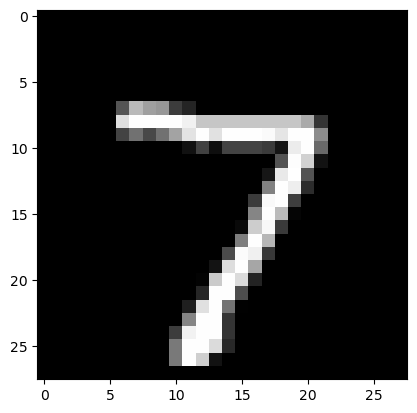

In [79]:
plt.imshow(x_test[0], cmap='gray')

In [10]:
layer = model.get_layer('dense_2')

In [11]:
import networkx as nx

In [8]:
import numpy as np

In [15]:
from topomaps.src.neuron_activations import get_NWPs

In [9]:

model = keras.models.load_model('saved_models/simple_mlp.keras')
#get_NWPs(model, 'MNIST', [0, 1], 1000, None)

In [21]:
import json
json_responses = []
for layer in model.layers:
    w = layer.get_weights()
    if bool(w):

        json_w = []
        for element in w:
            json_w.append(element.tolist())
        json_str = json.dumps(json_w)
        json_responses.append(json_str)

In [32]:
weights, biases = w

In [34]:
biases

array([-0.7144007 ,  0.12249441,  0.2842798 , -0.30744287,  0.1348489 ,
        1.5523825 , -0.40760717,  0.634764  , -1.1870548 , -0.1927688 ],
      dtype=float32)

In [35]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

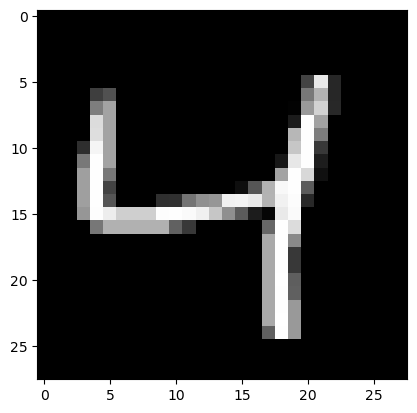

In [34]:
plt.imshow(x_train[2], cmap="gray")

In [116]:
model

In [9]:
sample_index = 0
sample = np.expand_dims(x_train[sample_index],0)
input_tensor = tf.convert_to_tensor(sample, dtype=tf.float32)

In [10]:
with tf.GradientTape() as tape:
    tape.watch(input_tensor)
    prediction = model(input_tensor)
    #predicted_class = tf.argmax(prediction[0])
    #target = tf.one_hot(predicted_class, prediction.shape[1])
    #loss = tf.reduce_sum(target * prediction)

In [11]:
gradients = tape.gradient(prediction, input_tensor).numpy()
feature_importance = np.abs(gradients[0])
feature_importance = feature_importance.reshape(x_train.shape[1:])

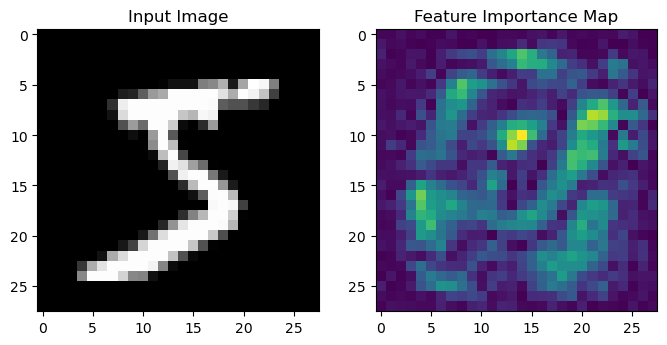

In [12]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(sample.reshape(28, 28), cmap='gray')
plt.title('Input Image')
plt.subplot(1, 2, 2)
plt.imshow(feature_importance, cmap='viridis')
plt.title('Feature Importance Map')
plt.show()

In [13]:
def integrated_gradients(model, baseline, image_sample, steps=50):
    alphas = tf.linspace(0.0, 1.0, steps)

    def interpolate_images(baseline, image_sample, alpha):
        return baseline + alpha * (image_sample - baseline)

    imgs = [interpolate_images(baseline, image_sample, alpha) for alpha in alphas]
    imgs = tf.concat(imgs, axis=0)

    with tf.GradientTape() as tape:
        tape.watch(imgs)
        logits = model(imgs)

    grads = tape.gradient(logits, imgs)
    avg_grads = tf.reduce_mean(grads, axis=0)

    integrated_grad = (image_sample - baseline) * avg_grads
    integrated_grad = tf.reduce_mean(integrated_grad, axis=0)  # Average along the steps dimension
    return integrated_grad

In [14]:
baseline = np.zeros_like(sample)

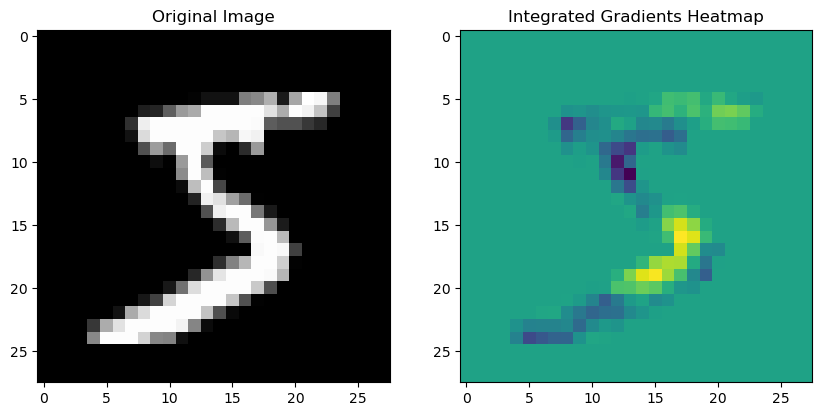

In [15]:
ig = integrated_gradients(model, baseline, sample)
ig = ig.numpy().reshape((28, 28))
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(sample.reshape(28, 28), cmap='gray')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(ig, cmap='viridis')
plt.title('Integrated Gradients Heatmap')

plt.show()

In [19]:
import json
json_w = []
for element in ig:
    json_w.append(element.tolist())
json_str = json.dumps(json_w)
json_str

'[[-0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0], [-0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0], [-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0], [-0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0], [0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0], [0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -2.206620693206787, -8.115216255187988, -2.4588329792022705, 12.850894927978516, 101.5012435913086, 91.40345764160156, 110.32425689697266, 23.78207015

In [202]:
def guided_backpropagation(model, input_image):
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = model(input_image)
        predicted_class = tf.argmax(prediction[0])
        target = tf.one_hot(predicted_class, prediction.shape[1])
        loss = tf.reduce_sum(target * prediction)

    gradient = tape.gradient(loss, input_image)

    # Suppress negative gradients and highlight positive gradients
    guided_gradient = tf.where(gradient > 0, gradient, 0)

    return guided_gradient


In [203]:
input_tensor = tf.convert_to_tensor(sample, dtype=tf.float32)
guided_gradient = guided_backpropagation(model, input_tensor)

guided_gradient = guided_gradient.numpy().reshape((28, 28))

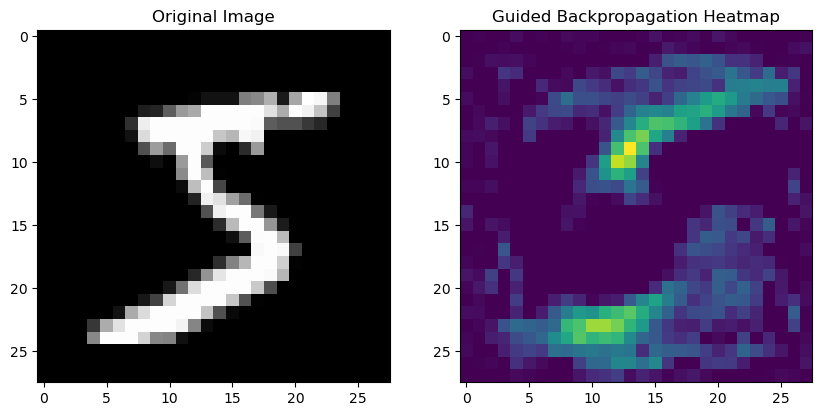

In [204]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(sample.reshape(28, 28), cmap='gray')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(guided_gradient, cmap='viridis')
plt.title('Guided Backpropagation Heatmap')

plt.show()